# Probabilistic Macrochemical Modeling: Scenario 1 *(constant cell weight)*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

figdims = (5, 3.6)  # figure dimensions in inches

In [2]:
import numpy as np
import pystan
import pickle
import pandas as pd
from scipy import stats
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['legend.numpoints'] = 1
from matplotlib.transforms import Bbox

from srbsim import SRBGrowthSim

## Generate data (constant cell weight)

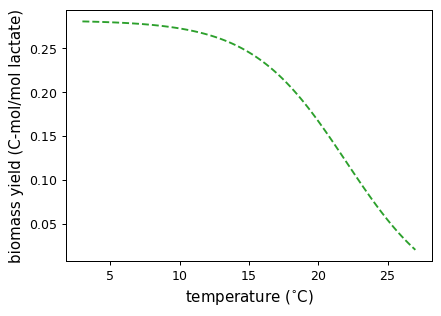

In [3]:
# auxiliary functions for specifying the curves
s = lambda x: 1./(1 + np.exp(-x))  # sigmoid
g = lambda x, e=2: np.exp(-0.5*(np.abs(x)**e))  # gaussian

# generation curves
def growth_rate_function(t, l0):
    return np.maximum(1e-6, 0.04*g((t-19)/10, e=1.6)*s(-1.0*(t-19-6/1.0)))

def biomass_yield_function(t, l0):
    return np.maximum(1e-6, 0.322*s(-(t-22)/3.4) - 0.04)

def cell_weight_function(t, l0):
    return 1.8e-13*(t > -10)

t = np.linspace(3, 27, 97)

fig = plt.figure(figsize=figdims, dpi=90)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

In [4]:
concentrations_noise = {
     'lactate': 0.15,
     'sulfate': 0.3,
     'acetate': 0.2,
     'bicarbonate': 0.8,
     'sulfide': 0.4}

# initialize the data generator
sim = SRBGrowthSim(biomass_yield_curve=biomass_yield_function,
                   cell_weight_curve=cell_weight_function,
                   concentrations_noise=concentrations_noise,
                   cell_count_noise=2e8)

conditions = [5, 10, 15, 20, 25]  # temperature conditions (in 'C)
n_conditions = len(conditions)
n_replicates = 3

# generate data
np.random.seed(20200601)
gt = []  # ground truth values
delta_conditions = []
for t in conditions:
    for i in range(n_replicates):
        latent, _, deltas = sim.generate(t, initial_cell_count=1e7)
        gt.append({
            'temp': t,
            'initial_biomass': latent[0],  # (C-mol)
            'final_biomass': latent[1],    # (C-mol)
            'lactate_cat': latent[2],      # (mM)
            'lactate_anab': latent[3]})    # (mM)
        deltas['temp'] = t
        delta_conditions.append(deltas)

# arrange data into DataFrames
gt_vals = pd.DataFrame(gt, columns=['temp', 'initial_biomass', 'final_biomass',
                                    'lactate_cat', 'lactate_anab'])
delta_vals = pd.DataFrame(delta_conditions,
                          columns=['temp', 'lactate', 'sulfate', 'acetate',
                                   'bicarbonate', 'sulfide', 'n_cells'])
delta_vals

,temp,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
0,5,-29.891545,-12.714893,27.015971,25.730172,13.524916,3.202839e+09
1,5,-29.864061,-13.636548,27.211480,28.860091,14.508144,3.438126e+09
2,5,-30.049761,-13.463471,27.215575,28.195255,13.539260,3.373052e+09
3,10,-30.301319,-12.920842,27.693236,28.319127,12.908176,3.578728e+09
4,10,-29.819079,-13.475302,27.332002,27.064108,12.620619,3.081149e+09
5,10,-30.266737,-13.561216,27.095586,28.701566,13.740277,3.286675e+09
6,15,-30.193569,-13.172566,27.015654,25.878538,15.042553,3.385461e+09
7,15,-29.617921,-13.751402,26.914417,26.109168,14.067182,3.154015e+09
8,15,-30.267264,-13.671174,27.629648,28.961052,14.268825,2.976059e+09
9,20,-29.660149,-14.611721,28.259595,30.229001,13.585194,1.907892e+09


## Estimation of biomass yields from *pairings* of compound measurements

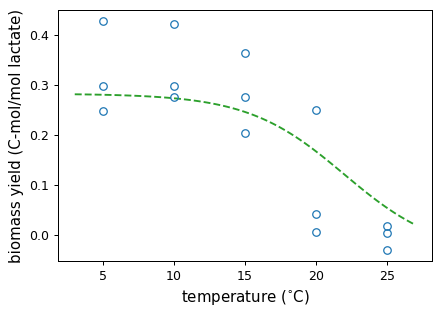

In [5]:
# estimation of biomass yield using lactate and sulfate measurements

lactate_cat = (1/0.5) * delta_vals['sulfate']  # sulfate is consumed at *half* the rate of lactate in the catabolic reaction
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_sulfate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_sulfate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

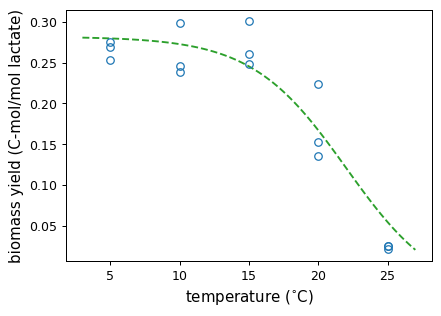

In [6]:
# estimation of biomass yield using lactate and acetate measurements

lactate_cat = -delta_vals['acetate']
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_acetate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_acetate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

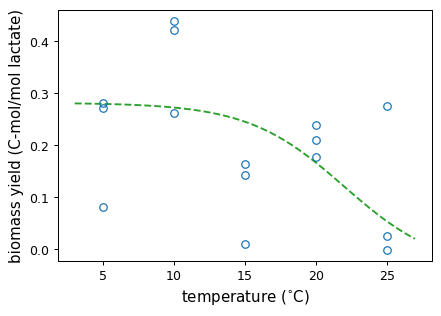

In [7]:
# estimation of biomass yield using lactate and sulfide measurements

lactate_cat = (1/-0.5) * delta_vals['sulfide']
lactate_anab = delta_vals['lactate'] - lactate_cat
biomass_produced = (1/-0.35) * lactate_anab
yield_from_sulfide =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_sulfide, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

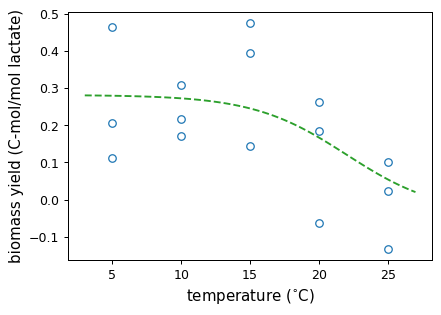

In [8]:
# estimation of biomass yield using lactate and bicarbonate measurements

biomass_produced = (-1/0.30)*(delta_vals['lactate'] + delta_vals['bicarbonate'])
yield_from_bicarbonate =  biomass_produced / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_bicarbonate, 'o', fillstyle='none')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

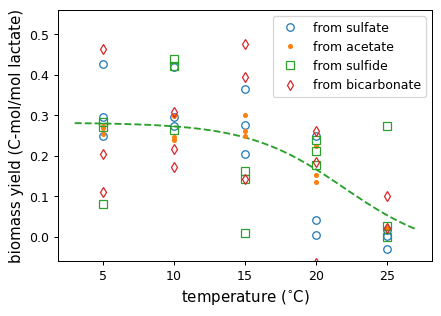

In [9]:
# combined estimates of biomass yields

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')

plt.plot(delta_vals['temp'], yield_from_sulfate, 'o', label='from sulfate', fillstyle='none')
plt.plot(delta_vals['temp'], yield_from_acetate, '.', label='from acetate')
plt.plot(delta_vals['temp'], yield_from_sulfide, 's', label='from sulfide', fillstyle='none')
plt.plot(delta_vals['temp'], yield_from_bicarbonate, 'd', label='from bicarbonate', fillstyle='none')

plt.ylim([-0.06, 0.56])
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.legend()
plt.tight_layout()

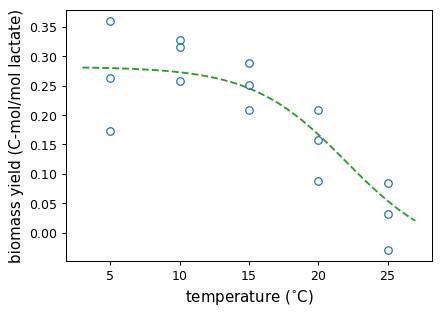

In [10]:
# average of estimates of biomass yields

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')

plt.plot(delta_vals['temp'], (1/4)*(yield_from_sulfate
                                    + yield_from_acetate
                                    + yield_from_sulfide
                                    + yield_from_bicarbonate), 'o', label='from average', fillstyle='none')

plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.tight_layout()

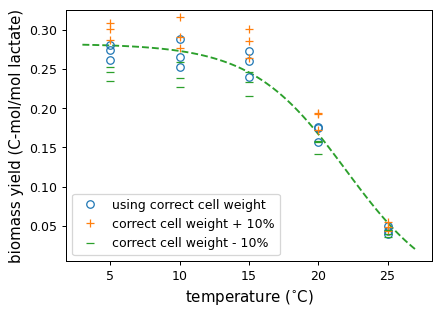

In [11]:
# estimation of biomass yield using lactate measurements and cell counts

biomass_produced = delta_vals['n_cells']*(1.8e-13/24.62)
yield_from_ncells =  biomass_produced*(1e3/sim.volume) / -delta_vals['lactate']

yield_from_ncells_plus =  (delta_vals['n_cells']*(1.1*1.8e-13/24.62))*(1e3/sim.volume) / -delta_vals['lactate']
yield_from_ncells_minus =  (delta_vals['n_cells']*(0.9*1.8e-13/24.62))*(1e3/sim.volume) / -delta_vals['lactate']

fig = plt.figure(figsize=figdims, dpi=90)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.plot(delta_vals['temp'], yield_from_ncells, 'o', fillstyle='none', label='using correct cell weight')
plt.plot(delta_vals['temp'], yield_from_ncells_plus, '+', label='correct cell weight + 10%')
plt.plot(delta_vals['temp'], yield_from_ncells_minus, '_', label='correct cell weight - 10%')
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.legend()
plt.tight_layout()

---

## Probabilistic model (*without* cell counts)

In [12]:
model_name = 'chemical_model_1a_noCellCounts'
model_code = """
    data {
        int<lower=0> M;         # number of conditions
        int<lower=0> R;         # number of replicates per condition
        real<lower=0> vol;      # volume to convert concentrations to millimoles (liters)
        
        # measured change in concentration of the different compounds (mM)
        vector<upper=0>[R] delta_lactate_obs[M];    
        vector<upper=0>[R] delta_sulfate_obs[M];
        vector<lower=0>[R] delta_acetate_obs[M];
        vector<lower=0>[R] delta_bicarbonate_obs[M];
        vector<lower=0>[R] delta_sulfide_obs[M];
    }

    parameters {
        # key hyperparameters for the catabolic vs anabolic split
        # change in lactate concentration due to catabolic and anabolic reactions (mM)
        real<upper=-1e-3> delta_lactate_cat[M];
        real<upper=-1e-3> delta_lactate_anab[M];
        
        # hyperparameters for standard deviation of experimental
        # measurements of concentration of the compounds
        real<lower=0> s_lactate;
        real<lower=0> s_sulfate;
        real<lower=0> s_acetate;
        real<lower=0> s_bicarbonate;
        real<lower=0> s_sulfide;
    }

    transformed parameters {
        real<lower=0> delta_biomass[M];             # change in biomass (millimoles)
        real<lower=0> biomass_yield[M];             # C-moles of biomass produced per mol of e- donor (Y_DX)
        real<lower=0> cat_scaling[M];               # scaling of cat reaction in macrochem eq

        for (m in 1:M) {
            delta_biomass[m] = -(1/0.35) * delta_lactate_anab[m] * vol;
            biomass_yield[m] = -delta_biomass[m] \
                                / ((delta_lactate_cat[m] + delta_lactate_anab[m]) * vol);
            cat_scaling[m] = 0.35 * delta_lactate_cat[m] / delta_lactate_anab[m];
        }
    }

    model {
        # priors on standard deviation of experimental measurements
        # (common to all conditions and replicates)
        real beta;
        beta = 1/0.1;
        s_lactate ~ exponential(beta);
        s_sulfate ~ exponential(beta);
        s_acetate ~ exponential(beta);
        s_sulfide ~ exponential(beta);
        s_bicarbonate ~ exponential(beta);

        for (m in 1:M) {
            # priors on key chemical concentrations
            delta_lactate_cat[m] ~ normal(-28, 0.5);   #-lognormal(3.33, 0.3);  # exp(3.33) ~= 28
            delta_lactate_anab[m] ~ normal(-2, 0.5);   #-lognormal(0.7, 0.3);    # exp(0.7) ~= 2

            # finally related key parameters to concentration measurements
            delta_lactate_obs[m] ~ normal(delta_lactate_cat[m] + delta_lactate_anab[m], s_lactate*sqrt(2));
            delta_sulfate_obs[m] ~ normal( 0.5*delta_lactate_cat[m], s_sulfate*sqrt(2));
            delta_acetate_obs[m] ~ normal(-1.0*delta_lactate_cat[m], s_acetate*sqrt(2));
            delta_sulfide_obs[m] ~ normal(-0.5*delta_lactate_cat[m], s_sulfide*sqrt(2));
            delta_bicarbonate_obs[m] ~ normal(-delta_lactate_cat[m]-(0.05/0.35)*delta_lactate_anab[m], s_bicarbonate*sqrt(2));
        }
    }
"""

fn = model_name + '.stan.pkl'
try:
    stan_model = pickle.load(open(fn, 'rb'))
    no_model_file = False
except Exception:
    no_model_file = True

if no_model_file or stan_model.model_code != model_code:
    print("(Re)compiling Stan model...")
    stan_model = pystan.StanModel(model_code=model_code,
                                  model_name=model_name)
    with open(fn, 'wb') as fh:
        pickle.dump(stan_model, fh)
    print("Cached model for reuse.")
else:
    print("Using cached model.")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chemical_model_1a_noCellCounts_e5eae8a7d4183039007eb53b36a6c180 NOW.


(Re)compiling Stan model...
Cached model for reuse.


In [13]:
model_fit_alldata = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates))},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

np.set_printoptions(precision=3, linewidth=90, suppress=True)
print(model_fit_alldata)

Inference for Stan model: chemical_model_1a_noCellCounts_e5eae8a7d4183039007eb53b36a6c180.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
delta_lactate_cat[1]  -27.24  2.3e-3   0.14 -27.53 -27.33 -27.24 -27.15  -26.97   3783    1.0
delta_lactate_cat[2]  -27.38  2.1e-3   0.14 -27.65 -27.47 -27.37 -27.29  -27.09   4312    1.0
delta_lactate_cat[3]  -27.32  2.8e-3   0.15 -27.63 -27.41 -27.31 -27.22  -27.05   2651    1.0
delta_lactate_cat[4]  -28.35  2.1e-3   0.14 -28.63 -28.44 -28.35 -28.26  -28.08   4200    1.0
delta_lactate_cat[5]  -29.31  2.8e-3   0.15 -29.57 -29.42 -29.32 -29.22  -28.98   2962    1.0
delta_lactate_anab[1]   -2.6  4.0e-3   0.22  -3.03  -2.75  -2.61  -2.47   -2.17   3175    1.0
delta_lactate_anab[2]  -2.66  3.6e-3   0.22  -3.09  -2.81  -2.66  -2.52   -2.23   3604    1.0
delta_lactate_anab[3]  -2.61  4.1e-3   

In [14]:
delta_vals.groupby('temp').mean()

,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
temp,,,,,,
5,-29.935122,-13.271637,27.147675,27.595173,13.857440,3.338005e+09
10,-30.129045,-13.319120,27.373608,28.028267,13.089691,3.315518e+09
15,-30.026252,-13.531714,27.186573,26.982919,14.459520,3.171845e+09
20,-30.123832,-14.535723,28.319897,28.959021,13.958407,2.093582e+09
25,-29.777712,-14.903975,29.533317,29.804716,14.366011,5.411787e+08


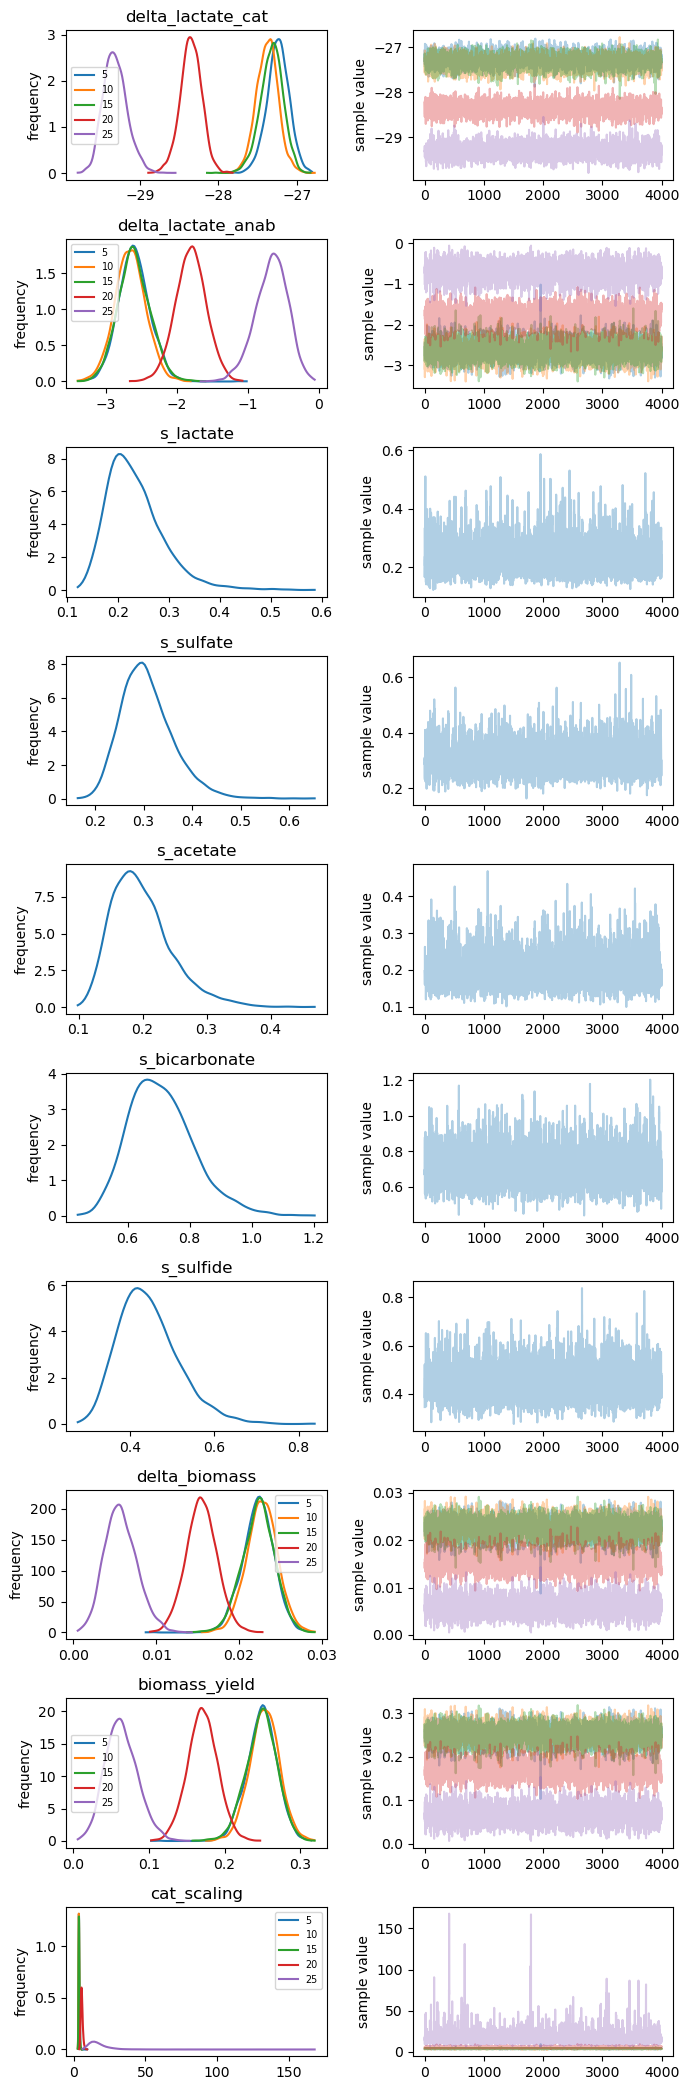

In [15]:
fig = model_fit_alldata.plot()
fig.set_size_inches(7, 21)
fig.set_dpi(100)
for i, a in enumerate(fig.axes):
    if i % 2 == 0 and len(a.get_lines()) > 1:
        a.legend(conditions, fontsize='x-small')
fig.tight_layout()
trim_bbox_in_inches = Bbox(np.array([[0, 0], [3.498, 21]]))

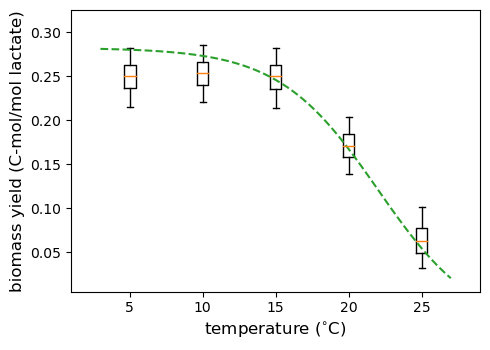

In [16]:
biomass_yield_samples = model_fit_alldata.extract('biomass_yield', permuted=True)['biomass_yield']

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.boxplot(biomass_yield_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
# plt.violinplot(biomass_yield_samples, positions=conditions,
#                widths=1.6, showmeans=True, showextrema=True)
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.tight_layout()

In [17]:
posterior_means = dict(zip(
    model_fit_alldata.flatnames,
    model_fit_alldata.get_posterior_mean().mean(axis=1)))

print('concentrations_noise =', {k:f'{v:.3f}' for k, v in concentrations_noise.items()})
print('estimated conc noise =', {k[2:]:(f'{v:.3g}' if 'cell_count' in k  else f'{v:.3f}') for k, v in posterior_means.items() if k.startswith('s_')})

concentrations_noise = {'lactate': '0.150', 'sulfate': '0.300', 'acetate': '0.200', 'bicarbonate': '0.800', 'sulfide': '0.400'}
estimated conc noise = {'lactate': '0.234', 'sulfate': '0.307', 'acetate': '0.199', 'bicarbonate': '0.711', 'sulfide': '0.444'}


----

## Probabilistic model (*with* cell counts)

In [18]:
model_name = 'chemical_model_1b_withCellCounts'
model_code = """
    data {
        int<lower=0> M;         # number of conditions
        int<lower=0> R;         # number of replicates per condition
        real<lower=0> vol;      # volume to convert concentrations to millimoles (liters)
        
        # measured change in concentration of the different compounds (mM)
        vector<upper=0>[R] delta_lactate_obs[M];    
        vector<upper=0>[R] delta_sulfate_obs[M];
        vector<lower=0>[R] delta_acetate_obs[M];
        vector<lower=0>[R] delta_bicarbonate_obs[M];
        vector<lower=0>[R] delta_sulfide_obs[M];

        # difference in cell counts
        vector<lower=0>[R] delta_ncells_obs[M];
    }

    parameters {
        # key hyperparameters for the catabolic vs anabolic split
        # change in lactate concentration due to catabolic and anabolic reactions (mM)
        real<upper=-1e-3> delta_lactate_cat[M];
        real<upper=-1e-3> delta_lactate_anab[M];
        
        # hyperparameters for standard deviation of experimental
        # measurements of concentration of the compounds and cell counts
        real<lower=0> s_lactate;
        real<lower=0> s_sulfate;
        real<lower=0> s_acetate;
        real<lower=0> s_bicarbonate;
        real<lower=0> s_sulfide;
        real<lower=0> s_cell_count;

        real<lower=1e-14, upper=2e-12> cell_weight;         # cell mean weight hyperparameter
    }

    transformed parameters {
        real<lower=0> delta_biomass[M];             # change in biomass (millimoles)
        real<lower=0> biomass_yield[M];             # C-moles of biomass produced per mol of e- donor (Y_DX)
        real<lower=0> cat_scaling[M];               # scaling of cat reaction in macrochem eq

        for (m in 1:M) {
            delta_biomass[m] = -(1/0.35) * delta_lactate_anab[m] * vol;
            biomass_yield[m] = -delta_biomass[m] \
                                / ((delta_lactate_cat[m] + delta_lactate_anab[m]) * vol);
            cat_scaling[m] = 0.35 * delta_lactate_cat[m] / delta_lactate_anab[m];
        }
    }

    model {
        # priors on standard deviation of experimental measurements
        # (common to all conditions and replicates)
        real c;
        c = 1/0.1;
        s_lactate ~ exponential(c);
        s_sulfate ~ exponential(c);
        s_acetate ~ exponential(c);
        s_sulfide ~ exponential(c);
        s_bicarbonate ~ exponential(c);

        # cell priors
        s_cell_count ~ exponential(1/1e8);
        cell_weight ~ lognormal(-29.346 + 0.09, 0.3);      # log(1.8e-13) = -29.346,
                                                           # mode is at (mu - sigma^2)

        for (m in 1:M) {
            # priors on key chemical concentrations
            delta_lactate_cat[m] ~ normal(-28, 0.5);   #-lognormal(3.33, 0.3);  # exp(3.33) ~= 28
            delta_lactate_anab[m] ~ normal(-2, 0.5);   #-lognormal(0.7, 0.3);    # exp(0.7) ~= 2

            # finally related key parameters to concentration measurements
            delta_lactate_obs[m] ~ normal(delta_lactate_cat[m] + delta_lactate_anab[m], s_lactate*sqrt(2));
            delta_sulfate_obs[m] ~ normal( 0.5*delta_lactate_cat[m], s_sulfate*sqrt(2));
            delta_acetate_obs[m] ~ normal(-1.0*delta_lactate_cat[m], s_acetate*sqrt(2));
            delta_sulfide_obs[m] ~ normal(-0.5*delta_lactate_cat[m], s_sulfide*sqrt(2));
            delta_bicarbonate_obs[m] ~ normal(-delta_lactate_cat[m]-(0.05/0.35)*delta_lactate_anab[m], s_bicarbonate*sqrt(2));

            # relate biomass estimates to observed cell growth
            delta_ncells_obs[m] ~ normal(delta_biomass[m] * 1e-3 * 24.62/cell_weight, s_cell_count);
        }
    }
"""

fn = model_name + '.stan.pkl'
try:
    stan_model = pickle.load(open(fn, 'rb'))
    no_model_file = False
except Exception:
    no_model_file = True

if no_model_file or stan_model.model_code != model_code:
    print("(Re)compiling Stan model...")
    stan_model = pystan.StanModel(model_code=model_code,
                                  model_name=model_name)
    with open(fn, 'wb') as fh:
        pickle.dump(stan_model, fh)
    print("Cached model for reuse.")
else:
    print("Using cached model.")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chemical_model_1b_withCellCounts_64248431a50bf4ab9cdffd1d7a3f5e72 NOW.


(Re)compiling Stan model...
Cached model for reuse.


In [19]:
model_fit_alldata = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates)),
          'delta_ncells_obs': np.array(delta_vals['n_cells']).reshape((n_conditions, n_replicates))},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

np.set_printoptions(precision=3, linewidth=90, suppress=True)
print(model_fit_alldata)

Inference for Stan model: chemical_model_1b_withCellCounts_64248431a50bf4ab9cdffd1d7a3f5e72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                         mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lactate_cat[1]   -27.19  1.9e-3    0.12  -27.42  -27.26  -27.18  -27.11  -26.96   3913    1.0
delta_lactate_cat[2]   -27.36  1.8e-3    0.11  -27.58  -27.43  -27.36  -27.28  -27.14   3642    1.0
delta_lactate_cat[3]   -27.31  2.1e-3    0.12  -27.55  -27.39  -27.31  -27.23  -27.09   3070    1.0
delta_lactate_cat[4]   -28.37  1.4e-3    0.11  -28.58  -28.44  -28.36  -28.29  -28.16   5495    1.0
delta_lactate_cat[5]   -29.39  1.6e-3    0.11   -29.6  -29.46  -29.39  -29.32  -29.16   4772    1.0
delta_lactate_anab[1]   -2.74  2.9e-3    0.12   -2.98   -2.82   -2.74   -2.66    -2.5   1772    1.0
delta_lactate_anab[2]   -2.73  3.0e-3    0.12   -2.97   -2.81   -2.73   -2.64   -2.48   1

In [20]:
delta_vals.groupby('temp').mean()

,lactate,sulfate,acetate,bicarbonate,sulfide,n_cells
temp,,,,,,
5,-29.935122,-13.271637,27.147675,27.595173,13.857440,3.338005e+09
10,-30.129045,-13.319120,27.373608,28.028267,13.089691,3.315518e+09
15,-30.026252,-13.531714,27.186573,26.982919,14.459520,3.171845e+09
20,-30.123832,-14.535723,28.319897,28.959021,13.958407,2.093582e+09
25,-29.777712,-14.903975,29.533317,29.804716,14.366011,5.411787e+08


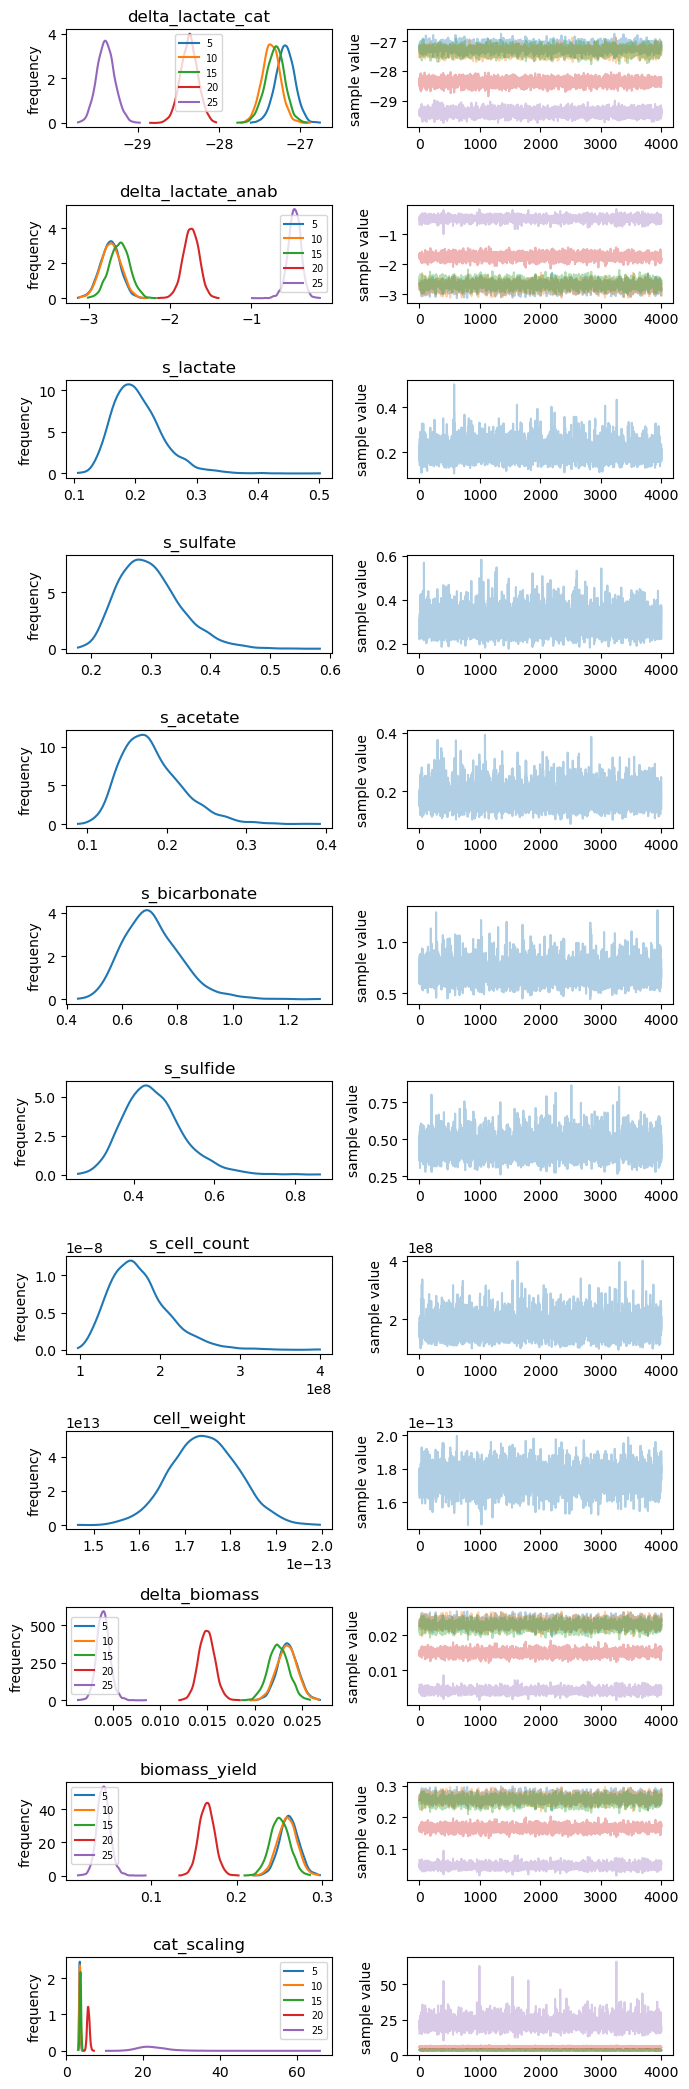

In [21]:
fig = model_fit_alldata.plot()
fig.set_size_inches(7, 21)
fig.set_dpi(100)
for i, a in enumerate(fig.axes):
    if i % 2 == 0 and len(a.get_lines()) > 1:
        a.legend(conditions, fontsize='x-small')
fig.tight_layout()
trim_bbox_in_inches = Bbox(np.array([[0, 0], [3.498, 21]]))

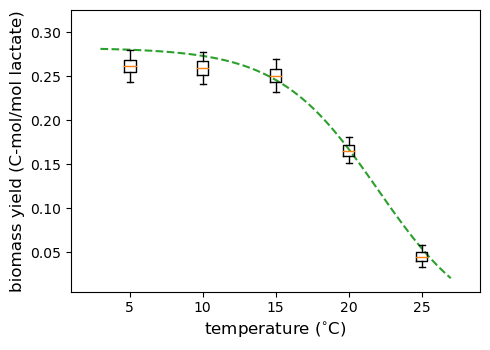

In [22]:
biomass_yield_samples = model_fit_alldata.extract('biomass_yield', permuted=True)['biomass_yield']

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.boxplot(biomass_yield_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.tight_layout()

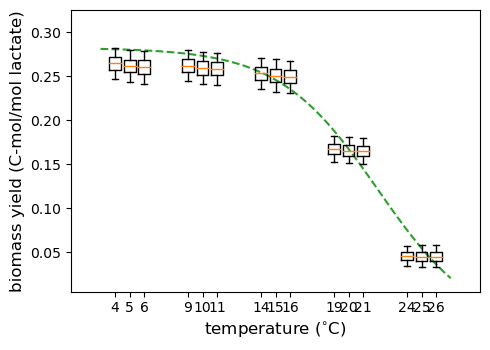

In [23]:
# Test fit if the ground-truth cell weight is +/- 50% of the estimate in the model prior.
#
# We achieve this by dividing the number of cells by a factor (0.5 or 1.5), which is
# equivalent to multiplying the ground-truth cell weight by the same factor, because
# the amount of biomass is the product of number of cells and cell weight.

model_fit_lowCellWeight = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates)),
          'delta_ncells_obs': np.array(delta_vals['n_cells']).reshape((n_conditions, n_replicates)) / 0.5},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

model_fit_highCellWeight = stan_model.sampling(
    data={'M': n_conditions,
          'R': n_replicates,
          'vol': sim.volume,
          'delta_lactate_obs': np.array(delta_vals['lactate']).reshape((n_conditions, n_replicates)),
          'delta_sulfate_obs': np.array(delta_vals['sulfate']).reshape((n_conditions, n_replicates)),
          'delta_acetate_obs': np.array(delta_vals['acetate']).reshape((n_conditions, n_replicates)),
          'delta_sulfide_obs': np.array(delta_vals['sulfide']).reshape((n_conditions, n_replicates)),
          'delta_bicarbonate_obs': np.array(delta_vals['bicarbonate']).reshape((n_conditions, n_replicates)),
          'delta_ncells_obs': np.array(delta_vals['n_cells']).reshape((n_conditions, n_replicates)) / 1.5},
    iter=2000, warmup=1000, chains=4,
    n_jobs=4, seed=20200601)

biomass_yield_samples_base = model_fit_alldata.extract('biomass_yield', permuted=True)['biomass_yield']
biomass_yield_samples_minus = model_fit_lowCellWeight.extract('biomass_yield', permuted=True)['biomass_yield']
biomass_yield_samples_plus = model_fit_highCellWeight.extract('biomass_yield', permuted=True)['biomass_yield']

plt.figure(figsize=figdims, dpi=100)
t = np.linspace(3, 27, 97)
plt.plot(t, biomass_yield_function(t, None), '--', color='tab:green')
plt.boxplot(biomass_yield_samples, positions=conditions,
            widths=0.8, sym='', whis=[5, 95])
plt.boxplot(biomass_yield_samples_minus, positions=np.array(conditions)-1,
            widths=0.8, sym='', whis=[5, 95])
plt.boxplot(biomass_yield_samples_plus, positions=np.array(conditions)+1,
            widths=0.8, sym='', whis=[5, 95])
plt.xlim(np.min(conditions)-4, np.max(conditions)+4)
plt.ylabel(r'biomass yield (C-mol/mol lactate)', fontsize='large')
plt.xlabel(r'temperature ($\!^\circ\!$C)', fontsize='large')
plt.ylim(0.005, 0.325)
plt.tight_layout()

In [24]:
np.set_printoptions(precision=3, linewidth=90, suppress=True)
print(model_fit_lowCellWeight)

Inference for Stan model: chemical_model_1b_withCellCounts_64248431a50bf4ab9cdffd1d7a3f5e72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                         mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lactate_cat[1]   -27.17  1.8e-3    0.11   -27.4  -27.25  -27.17   -27.1  -26.96   4001    1.0
delta_lactate_cat[2]   -27.35  1.6e-3    0.11  -27.56  -27.43  -27.35  -27.28  -27.13   4389    1.0
delta_lactate_cat[3]    -27.3  1.8e-3    0.11  -27.53  -27.37   -27.3  -27.23  -27.08   3867    1.0
delta_lactate_cat[4]   -28.36  1.6e-3    0.11  -28.58  -28.43  -28.36  -28.29  -28.15   4518    1.0
delta_lactate_cat[5]   -29.39  1.6e-3    0.11   -29.6  -29.46  -29.39  -29.32  -29.17   4857    1.0
delta_lactate_anab[1]   -2.77  3.0e-3    0.12   -3.01   -2.85   -2.77   -2.69   -2.53   1682    1.0
delta_lactate_anab[2]   -2.76  2.8e-3    0.12    -3.0   -2.84   -2.76   -2.68   -2.52   1

In [25]:
posterior_means = dict(zip(
    model_fit_alldata.flatnames,
    model_fit_alldata.get_posterior_mean().mean(axis=1)))

print('concentrations_noise =', {k:f'{v:.3f}' for k, v in concentrations_noise.items()})
print('estimated conc noise =', {k[2:]:(f'{v:.3g}' if 'cell_count' in k  else f'{v:.3f}') for k, v in posterior_means.items() if k.startswith('s_')})

concentrations_noise = {'lactate': '0.150', 'sulfate': '0.300', 'acetate': '0.200', 'bicarbonate': '0.800', 'sulfide': '0.400'}
estimated conc noise = {'lactate': '0.204', 'sulfate': '0.299', 'acetate': '0.181', 'bicarbonate': '0.710', 'sulfide': '0.451', 'cell_count': '1.74e+08'}
